In [56]:
%matplotlib inline
#%reset
import sys
import numpy as np
import os
import math
import cv2
import shutil
import time
import random
import matplotlib.image as img
import tensorflow as tf
import itertools
from PIL import Image

from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization, GridSearch



# ensure we are training on GPU
# print(tf.__version__)
# print(tf.__file__)
# print(tf.config.list_physical_devices())
#print(tf.config.list_physical_devices('GPU'))

from tensorflow import keras
from keras.callbacks import EarlyStopping
#from IPython.display import Image, display
import matplotlib.pyplot as plt

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

In [57]:
# set random seed to ensure determinism for hyperparameter comparison, without shuffling
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()

Found 12488 images in the cat directory.
Found 12487 images in the dog directory.


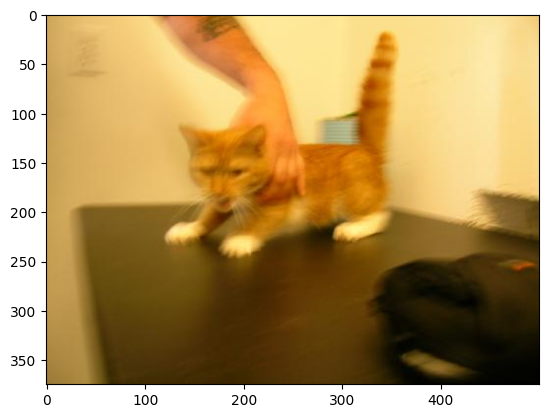

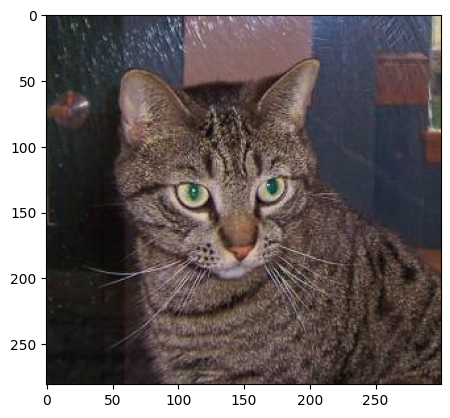

In [58]:
BASE_IMAGE_DIR = "C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages"

CAT_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Cat')
DOG_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Dog')
CORRUPTED_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'corrupted')
TRAINED_MODELS_DIR = os.path.join(BASE_IMAGE_DIR, 'models')
SAVE_DIR = r"C:\dev\programming_2023\cnn_project\training_plots"

if not os.path.exists(CORRUPTED_IMAGE_DIR):
    print("Creating {}".format(CORRUPTED_IMAGE_DIR))
    os.mkdirs(CORRUPTED_IMAGE_DIR)
    
if not os.path.exists(TRAINED_MODELS_DIR):
    print("Creating {}".format(TRAINED_MODELS_DIR))
    os.mkdirs(TRAINED_MODELS_DIR)

    
print("Found {} images in the cat directory.".format(len(os.listdir(CAT_IMAGE_DIR))))
print("Found {} images in the dog directory.".format(len(os.listdir(DOG_IMAGE_DIR))))

# display the first 2 images of the cat directory as a santity check
first_images = os.listdir(CAT_IMAGE_DIR)[:2]
for image in first_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    plt.imshow(test_img)
    plt.show()
    


In [59]:
cat_images = os.listdir(CAT_IMAGE_DIR)
for image in cat_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

dog_images = os.listdir(DOG_IMAGE_DIR)
for image in dog_images:
    test_img_path = "{}/{}".format(DOG_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

In [60]:
class CatDogImageHypermodel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.models.Sequential()

        # First convolutional layer
        model.add(keras.layers.Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

        # Second convolutional layer
        model.add(keras.layers.Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                         activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

        # Flatten and dense layers
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=16),
                        activation='relu'))
        model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model

In [61]:
def run_search_and_train(search_function, hypermodel, train_data, val_data, num_trials, num_epochs):
    best_model, best_hyperparameters = search_function(hypermodel, train_data, val_data, num_trials, num_epochs)
    best_model.summary()
    print("Best hyperparameters found: ", best_hyperparameters)

    # Train the model with the best hyperparameters
    history = best_model.fit(train_data,
                             epochs=num_epochs,
                             validation_data=val_data,
                             callbacks=[EarlyStopping(patience=3)])

    return history, best_hyperparameters


def plot_history(history, save_dir, search_method):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Accuracy - {}'.format(search_method))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Loss - {}'.format(search_method))
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.savefig(os.path.join(save_dir, '{}_plot.png'.format(search_method)))
    plt.show()

def plot_compare_hyperparameters(results, save_dir):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    for search_method, history in results.items():
        ax1.plot(history.history['val_accuracy'], label=search_method)
        ax1.set_title('Validation Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        ax2.plot(history.history['val_loss'], label=search_method)
        ax2.set_title('Validation Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()

    plt.savefig(os.path.join(save_dir, 'comparison_plot.png'))
    plt.show()


In [62]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = train_datagen.flow_from_directory(BASE_IMAGE_DIR, target_size=(150, 150), batch_size=32, class_mode='binary', subset='training', seed=42)
val_data = train_datagen.flow_from_directory(BASE_IMAGE_DIR, target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation', seed=42)


Found 19982 images belonging to 4 classes.
Found 4994 images belonging to 4 classes.


In [63]:
input_shape = (150, 150, 3)
num_classes = 2
num_trials = 10
num_epochs = 20

hypermodel = CatDogImageHypermodel(input_shape, num_classes)

grid_search = GridSearch(hypermodel, objective='val_accuracy', max_trials=num_trials, seed=seed_value)
bayesian_optimization_search = BayesianOptimization(hypermodel, objective='val_accuracy', max_trials=num_trials, seed=seed_value)

grid_history, grid_best_hyperparameters = run_search_and_train(grid_search, hypermodel, train_data, val_data, num_trials, num_epochs)
bayesian_history, bayesian_best_hyperparameters = run_search_and_train(bayesian_optimization_search, hypermodel, train_data, val_data, num_trials, num_epochs)


TypeError: 'GridSearch' object is not callable

In [ ]:
plot_history(grid_history, SAVE_DIR, 'Grid Search')
plot_history(bayesian_history, SAVE_DIR, 'Bayesian Optimization')

results = {
    'Grid Search': grid_history,
    'Bayesian Optimization': bayesian_history
}
plot_compare_hyperparameters(results, SAVE_DIR)
